# Handwritten Math Equation Solver

This document details a machine learning project implemented in a Python notebook. The project utilizes Optical Character Recognition (OCR) powered by a Convolutional Neural Network (CNN) to recognize handwritten mathematical equations drawn on a digital drawing pad and subsequently computes the solution.

### **1. Problem Statement**
- **The Problem:** Accurately recognizing and solving handwritten mathematical equations entered via a digital interface presents a significant challenge. Variability in handwriting styles, the similarity between certain characters (e.g., '1' and 'l', '5' and 'S'), and the need to correctly identify both numbers and mathematical operators require robust recognition capabilities. Failure to accurately recognize even a single character or operator can lead to incorrect parsing and computation, resulting in a completely wrong answer. We aim to achieve character recognition accuracy exceeding 95% on a held-out test set and correctly solve at least 90% of simple, well-formed arithmetic equations drawn by users.
- **Importance:** Automating the interpretation of handwritten mathematics bridges the gap between traditional pen-and-paper work and digital computation. This is crucial for:
- **Educational Tools:** Creating interactive learning platforms where students can practice math by writing, and the system provides instant feedback or solutions.
- **Accessibility:** Assisting individuals who find keyboard input difficult or prefer handwritten input.
- **Productivity:** Enabling faster input of mathematical expressions in various software applications compared to typing complex equations using specialized editors.
- **Target Audience:** This project is relevant to educators, students, software developers creating educational or scientific applications, and researchers in the fields of machine learning and human-computer interaction. 


### **2. Approach and Tools**

**Approach**

- **Input:** Capture user handwriting input as an image from a digital drawing pad interface integrated within the notebook.   
- **Preprocessing:** Convert the captured image to grayscale and apply adaptive thresholding to create a binary image.   
- **Character Segmentation:** Detect contours in the preprocessed image to identify potential character regions. Implement a merging strategy specifically for multi-part symbols like the division sign ('/') by merging bounding boxes that are vertically aligned and close. Sort the detected character bounding boxes based on their x-coordinate to maintain the equation's sequence.   
- **Character Preprocessing:** For each segmented character region (ROI):
Crop the character from the main image.   
Resize the character image to a standard size (e.g., 45x45 pixels) while maintaining its aspect ratio, adding padding, and centering it on a white background. This ensures uniformity for the recognition model.   
- **Character Recognition (OCR):** Feed the preprocessed character image into a pre-trained Convolutional Neural Network (CNN) to classify it as a digit (0-9) or a mathematical symbol (+, -, *, /, =).   
- **Equation Assembly:** Combine the recognized characters in sequence to form the complete mathematical equation string. Replace recognized symbol names ('times', 'divide') with their corresponding operators ('*', '/'). 
- **Equation Solving:** Evaluate the assembled equation string using Python's eval() function to compute the result.   
- **Output:** Display the recognized equation and the calculated answer.   


**Software Tools:**

- **Python:** The core programming language.
- **PyTorch:** Deep learning framework used for building and loading the CNN model.   
- **Torchvision:** Provides datasets and image transformations for PyTorch.   
- **OpenCV (cv2):** Library for computer vision tasks like image preprocessing (grayscaling, thresholding), contour detection, and image manipulation.   
- **NumPy:** Library for numerical operations, especially array manipulation for images.   
- **PIL (Pillow):** Library for opening, manipulating, and saving image files.   
- **Matplotlib:** Library for plotting images and visualization.   
- **ipywidgets & ipycanvas:** Libraries used to create the interactive drawing pad within the Jupyter notebook environment.   
- **os, random, ast:** Standard Python libraries for interacting with the operating system, generating randomness, and safe evaluation.   


### **3. Theoretical Foundations**

The core of the character recognition component is a Convolutional Neural Network (CNN). CNNs are a class of deep neural networks particularly well-suited for analyzing visual imagery.

Key Concepts:

- **Convolutional Layers:** These layers apply filters (kernels) across the input image to detect features like edges, corners, and textures. Early layers detect simple features, while deeper layers combine these to recognize more complex patterns.   
- **Activation Functions (ReLU):** Rectified Linear Unit (ReLU) introduces non-linearity into the model, allowing it to learn more complex relationships in the data.   
- **Pooling Layers (MaxPool):** These layers reduce the spatial dimensions (width, height) of the feature maps, making the model more robust to variations in the position of features and reducing computational complexity.   
- **Fully Connected Layers:** After several convolutional and pooling layers, the flattened output is fed into one or more fully connected layers, which perform classification based on the extracted features.   
- **Softmax (implied):** Although not explicitly shown in the forward method definition, a softmax function is typically applied to the final layer's output during training (often integrated into the loss function like CrossEntropyLoss) to produce probability scores for each class (character/symbol). The class with the highest probability is chosen as the prediction.   
- **Model Architecture:**   

    1. Conv2d (1 input channel, 32 output channels, kernel size 3, padding 1) -> ReLU -> MaxPool2d (kernel size 2, stride 2)
    2. Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1) -> ReLU -> MaxPool2d (kernel size 2, stride 2)
    3. Conv2d (64 input channels, 128 output channels, kernel size 3, padding 1) -> ReLU -> MaxPool2d (kernel size 2, stride 2)
    4. Flatten
    5. Linear (Input size calculated based on pooled feature map dimensions, 512 output units) -> ReLU
    6. Linear (512 input units, num_classes output units)

This architecture progressively extracts features and reduces dimensionality before making a final classification.

4. Dataset Description

idk

In [ ]:
# Import packages

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ast # For safe evaluation
import random
import os
import random
import numpy as np

In [ ]:
# Define the CNN architecture (must be the same as during training)

class CharacterRecognizerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterRecognizerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_input_size = 128 * (45 // (2**3)) * (45 // (2**3)) # Assuming img_size = 45
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

        self.img_size = 45

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the class names (important for mapping predictions back to characters)
data_dir = './Dataset/Dataset' # Adjust if needed
train_dir = os.path.join(data_dir, 'train')
train_dataset = datasets.ImageFolder(train_dir) # No transform needed here
class_names = train_dataset.classes
num_classes = len(class_names)

# Load the trained model
model = CharacterRecognizerCNN(num_classes)
model.load_state_dict(torch.load('./character_recognizer.pth', map_location=torch.device('cpu')))
model.eval() # Set the model to evaluation mode for inference

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

print("Trained model loaded.")
print(f"Class names: {class_names}")

Trained model loaded.
Class names: ['decimal', 'divide', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image as PILImage
import numpy as np
from ipycanvas import Canvas

# Config
canvas_width = 200
canvas_height = 80
line_color = "#000000"  # Black
background_color = "white"
line_width = 2

# Canvas
canvas = Canvas(width=canvas_width, height=canvas_height, sync_image_data=True)
canvas.fill_style = background_color
canvas.fill_rect(0, 0, canvas_width, canvas_height)
canvas.stroke_style = line_color
canvas.line_width = line_width
canvas.line_cap = 'round'
canvas.line_join = 'round'

# UI
clear_button = widgets.Button(description="Clear")
save_button = widgets.Button(description="Save Image")
output_area = widgets.Output()

# Storage
equation_image = None

class SketchPad:
    def __init__(self, canvas):
        self.canvas = canvas
        self._is_drawing = False
        self._last_x = None
        self._last_y = None
        self._setup_event_handlers()

    def _setup_event_handlers(self):
        self.canvas.on_mouse_down(self._start_path)
        self.canvas.on_mouse_move(self._draw_segment)
        self.canvas.on_mouse_up(self._end_path)
        self.canvas.on_mouse_out(self._end_path)

    def _start_path(self, x, y):
        self._is_drawing = True
        self._last_x = x
        self._last_y = y
        self.canvas.begin_path()
        self.canvas.move_to(x, y)

    def _draw_segment(self, x, y):
        if not self._is_drawing:
            return
        self.canvas.line_to(x, y)
        self.canvas.stroke()
        self.canvas.begin_path()
        self.canvas.move_to(x, y)
        self._last_x = x
        self._last_y = y

    def _end_path(self, x=None, y=None):
        if not self._is_drawing:
            return
        if x is not None and y is not None:
            self.canvas.line_to(x, y)
            self.canvas.stroke()
        self._is_drawing = False
        self._last_x = None
        self._last_y = None

    def clear(self):
        self.canvas.clear()
        self.canvas.fill_style = background_color
        self.canvas.fill_rect(0, 0, self.canvas.width, self.canvas.height)
        self.canvas.stroke_style = line_color
        self.canvas.line_width = line_width
        self.canvas.line_cap = 'round'
        self.canvas.line_join = 'round'

    def get_image(self):
        try:
            image_data = self.canvas.get_image_data()
            return PILImage.fromarray(image_data, 'RGBA') if image_data is not None and image_data.shape[0] > 0 else None
        except Exception as e:
            print(f"Error retrieving image: {e}")
            return None

# Init
drawing_pad = SketchPad(canvas)

# Buttons
def handle_clear_click(button):
    with output_area:
        clear_output()
        drawing_pad.clear()
        global captured_image
        equation_image = None
        print("Canvas has been cleared.")

def handle_save_click(button):
    global equation_image
    image = drawing_pad.get_image()
    with output_area:
        clear_output(wait=True)
        if image:
            equation_image = image
            print(f"Image captured (mode={image.mode}, size={image.size}).")
            display(image)
        else:
            print("No image data available. Please draw something.")

# Make Buttons Do Things
clear_button.on_click(handle_clear_click)
save_button.on_click(handle_save_click)

# Display
display(widgets.VBox([
    canvas,
    widgets.HBox([clear_button, save_button]),
    output_area
]))

# The 'captured_image' variable now holds the PIL Image object
# after you click the "Save Image" button.

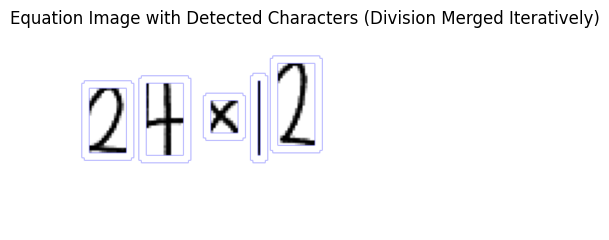

Detected 5 character regions


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Make sure this is imported

def is_fully_within_x(inner_rect, outer_rect):
    """Checks if the x-range of inner_rect is fully within outer_rect."""
    inner_x_start, _, inner_width, _ = inner_rect
    outer_x_start, _, outer_width, _ = outer_rect
    return outer_x_start <= inner_x_start and (inner_x_start + inner_width) <= (outer_x_start + outer_width)

def merge_rects(rect1, rect2):
    """Merges two bounding boxes into one."""
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return (new_x, new_y, new_w, new_h)

def detect_contours_and_merge_division(image):
    # Convert PIL Image to OpenCV format (NumPy array)
    open_cv_image = np.array(image)
    # Convert RGB to grayscale if it's a color image
    if len(open_cv_image.shape) == 3:
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = open_cv_image

    # Binarize the image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get initial bounding boxes
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    if not rects:
        return []

    # Sort bounding boxes by x-coordinate
    rects.sort(key=lambda x: x[0])

    merged = True
    while merged:
        merged = False
        new_rects = []
        n = len(rects)
        merged_indices = [False] * n
        for i in range(n):
            if not merged_indices[i]:
                current_rect = rects[i]
                for j in range(i + 1, n):
                    if not merged_indices[j]:
                        other_rect = rects[j]
                        if is_fully_within_x(current_rect, other_rect) or is_fully_within_x(other_rect, current_rect):
                            current_rect = merge_rects(current_rect, other_rect)
                            merged_indices[i] = True
                            merged_indices[j] = True
                            merged = True
                new_rects.append(current_rect)
        rects = new_rects

    # Filter out very small boxes (potential noise)
    min_area = 20
    filtered_rects = [(x, y, w, h) for x, y, w, h in rects if w * h > min_area]
    return filtered_rects

# Example usage (assuming 'equation_image' is a PIL Image object):
if 'equation_image' in locals():
    bounding_boxes = detect_contours_and_merge_division(equation_image)

    # Draw bounding boxes on the image for visualization
    image_with_boxes = np.array(equation_image).copy()
    if len(image_with_boxes.shape) == 2:
        image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_GRAY2BGR)
    else:
        image_with_boxes = image_with_boxes.copy()

    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2) # Red boxes

    plt.imshow(image_with_boxes)
    plt.title("Equation Image with Detected Characters (Division Merged Iteratively)")
    plt.axis('off')
    plt.show()

    print(f"Detected {len(bounding_boxes)} character regions")
else:
    print("Please load 'equation_image' (a PIL Image object) to run the example.")

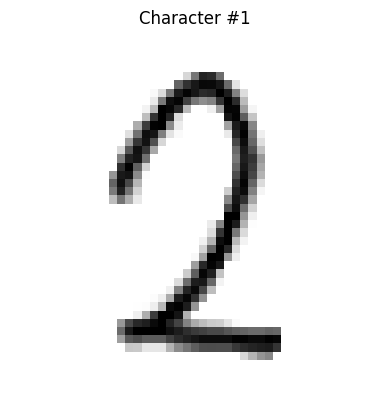

Recognized: 2


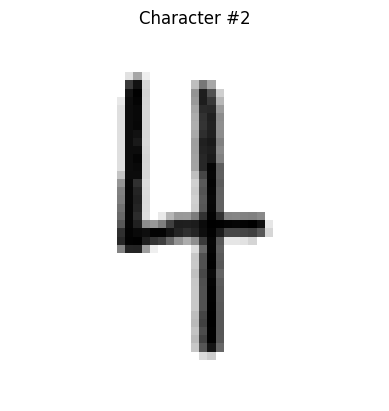

Recognized: 4


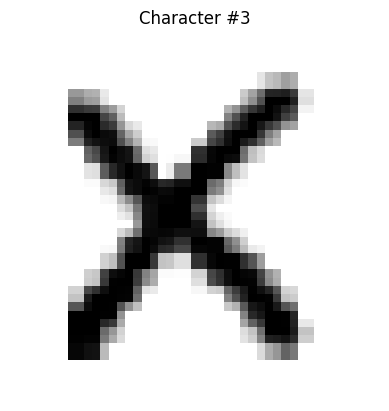

Recognized: ×


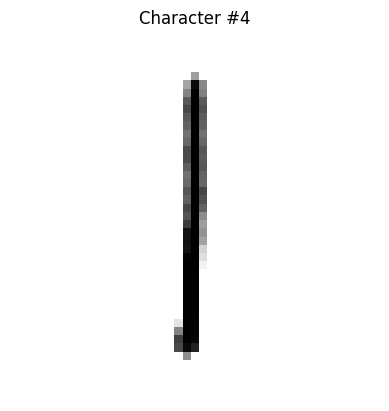

Recognized: 1


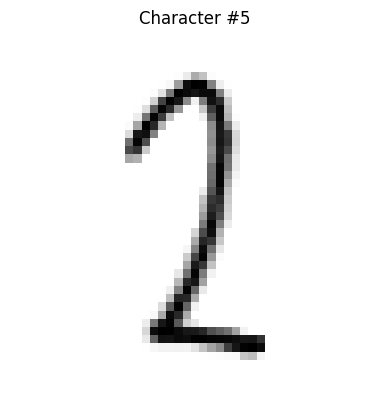

Recognized: 2

Recognized Equation: 24*12
Answer: 288


In [13]:
import matplotlib.pyplot as plt
# Add the new preprocess_symbol function here
def preprocess_symbol(char_roi, target_size=(45, 45), padding=5):
    """
    Process the cropped symbol to maintain its aspect ratio and quality:
    1. Create a blank (white) square image of the target size
    2. Resize the symbol while maintaining aspect ratio
    3. Center the symbol in the blank image
    """
    # Create a white background image
    background = np.ones((target_size[0], target_size[1]), dtype=np.uint8) * 255
    
    # Get dimensions of the character ROI
    h, w = char_roi.shape[:2]
    
    # Calculate the aspect ratio and determine new dimensions
    aspect_ratio = w / h
    
    # Calculate new dimensions while maintaining aspect ratio
    # Leave some padding around the character
    max_dim = max(target_size) - (padding * 2)
    
    if aspect_ratio > 1:  # Width is greater than height
        new_width = max_dim
        new_height = int(new_width / aspect_ratio)
    else:  # Height is greater than or equal to width
        new_height = max_dim
        new_width = int(new_height * aspect_ratio)
    
    # Resize the character image
    resized_char = cv2.resize(char_roi, (new_width, new_height), 
                             interpolation=cv2.INTER_AREA)
    
    # Calculate position to center the character in the background
    x_offset = (target_size[1] - new_width) // 2
    y_offset = (target_size[0] - new_height) // 2
    
    # Place the character in the center of the background
    background[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_char
    
    return background

# Mapping from class names to readable characters
symbol_map = {
    "plus": "+",
    "minus": "-",
    "times": "×",
    "divide": "÷",
    "equals": "=",
    "decimal": ".",
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9",
    "zero": "0",
    # Add more if needed
}

# Define the transformations - MODIFY THIS PART to remove the resize step
recognition_transforms = transforms.Compose([
    # Removed the resize step since we're handling it in preprocess_symbol
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

recognized_characters = []
if equation_image and bounding_boxes:
    open_cv_image = np.array(equation_image)
    if len(open_cv_image.shape) == 3:
        open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    for i, (x, y, w, h) in enumerate(sorted(bounding_boxes, key=lambda i: i[0])):
        char_roi = open_cv_image[y:y + h, x:x + w]
        
        # Process the character while maintaining aspect ratio - ADD THIS LINE
        processed_char = preprocess_symbol(char_roi)
        
        # Convert to PIL image - MODIFY THIS LINE
        char_pil = Image.fromarray(processed_char)
        
        # Show the processed character image
        plt.imshow(char_pil, cmap='gray')
        plt.title(f"Character #{i + 1}")
        plt.axis('off')
        plt.show()
        
        # Transform and predict with the processed character
        input_tensor = recognition_transforms(char_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_idx = torch.max(output, 1)
            predicted_label = class_names[predicted_idx[0]]
            readable_char = symbol_map.get(predicted_label, predicted_label)
            recognized_characters.append(readable_char)
            print(f"Recognized: {readable_char}")

    recognized_equation = "".join(recognized_characters).replace('×', '*').replace('÷', '/')
    try:
        answer = eval(recognized_equation)
        print(f"\nRecognized Equation: {recognized_equation}")
        print(f"Answer: {answer}")
    except (SyntaxError, TypeError, NameError, ZeroDivisionError) as e:
        print(f"\nError evaluating equation: {recognized_equation} - {e}")
else:
    print("No equation image or bounding boxes found.")


### **6. Results Summary**

The execution pipeline demonstrated in the notebook successfully performs the end-to-end task:

An equation ("24 x 12") was drawn on the interactive drawing pad.
The detect_contours_and_merge_division function successfully identified 5 distinct character regions, applying bounding boxes.   
Each character region was individually preprocessed using the preprocess_symbol function, ensuring consistent size and aspect ratio preservation while centering the character. Visualizations confirm this preprocessing step.   

The pre-trained CNN model (CharacterRecognizerCNN) recognized each preprocessed character image correctly: '2', '4', 'x' (times), '1', '2'.   
The recognized characters were assembled into the string "24*12" (after mapping 'x' to '*').  

The eval() function successfully computed the result of the recognized expression.  

Solution Computed: The model interpreted the handwritten input as the equation "24*12" and calculated the answer to be 288. This demonstrates the successful integration of the drawing pad, image processing, OCR via CNN, and mathematical evaluation components.   
